In [17]:
import pytz
from datetime import datetime

import os
import re


def find_files(base_dir, prefix, suffix):
    target_files = []

    # Walk through the directory structure
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.startswith(prefix) and file.endswith(suffix):
                target_files.append(os.path.join(root, file))
    return target_files


def format_datetime_as_iso_8601(dt: datetime):
    """
    Format the time in the EDT timezone
    :param dt: 
    :return: 
    """
    return dt.isoformat()


def append_timezone(dt: datetime, timezone_str: str, is_dst: bool = True):
    timezone = pytz.timezone(timezone_str)
    dt_aware = timezone.localize(dt, is_dst=is_dst)  # is_dst=True for daylight saving time
    return dt_aware


def append_edt_timezone(dt: datetime, is_dst: bool = True):
    return append_timezone(dt, "US/Eastern", is_dst)


def parse_nuttcp_timestamp(timestamp):
    # Parse the timestamp in the format of "2024-05-27 15:00:00.000000"
    return datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S.%f")


def format_nuttcp_timestamp(dt_str: str):
    dt = parse_nuttcp_timestamp(dt_str)
    dt_edt = append_edt_timezone(dt)
    return format_datetime_as_iso_8601(dt_edt)


def parse_nuttcp_tcp_result(content):
    # Regular expression to match the target line
    pattern = re.compile(
        r"\[(.*?)\]\s+.*?=\s+([\d.]+)\s+Mbps\s+(\d+)\s+retrans\s+(\d+)\s+KB-cwnd"
    )

    extracted_data = []

    for line in content.splitlines():
        match = pattern.search(line)
        if match:
            dt, throughput, retrans, cwnd = match.groups()
            dt_isoformat = format_nuttcp_timestamp(dt)
            row = [dt_isoformat, throughput, retrans, cwnd]
            extracted_data.append(','.join(row))
    return extracted_data

def parse_nuttcp_udp_result(content):
    pattern = re.compile(r'\[(.*?)\]\s+.*=\s+([\d.]+) Mbps\s+([-\d]+) /\s+(\d+) ~drop/pkt\s+([-\d.]+) ~%loss')

    extracted_data = []
    for line in content.splitlines():
        match = pattern.search(line)
        if match:
            dt, throughput, pkt_drop, pkt_total, loss = match.groups()
            dt_isoformat = format_nuttcp_timestamp(dt)
            row = [dt_isoformat, throughput, pkt_drop, pkt_total, loss]
            extracted_data.append(','.join(row))
    return extracted_data

def parse_iperf_udp_result(content: str):
        # Regular expression to match the target line
    pattern = re.compile(
        r"\[(.*?)\]\s+\[\s*\d+\]\s+[\d.]+-[\d.]+\s+sec\s+[\d.]+\s+MBytes\s+([\d.]+)\s+Mbits/sec\s+[\d.]+\s+ms\s+(\d+)/(\d+)\s+\((\d+)%\)"
    )
    
    extracted_data = []
    
    for line in content.splitlines():
        match = pattern.search(line)
        if match:
            timestamp, throughput, pkt_drop, pkt_total, loss = match.groups()
            extracted_data.append([timestamp, throughput, pkt_drop, pkt_total, loss])
    
    return extracted_data

def save_to_csv(data, output_file):
    header = ['time', 'throughput_mbps', 'retrans', 'cwnd_kb']
    with open(output_file, 'w') as f:
        f.write(','.join(header) + '\n')
        for line in data:
            f.write(line + '\n')
            
def save_udp_data_to_csv(data, output_file):
    header = ['time', 'throughput_mbps', 'pkt_drop', 'pkt_total', 'loss']
    with open(output_file, 'w') as f:
        f.write(','.join(header) + '\n')
        for line in data:
            f.write(line + '\n')
            
def find_tcp_downlink_file(base_dir):
    return find_files(base_dir, prefix="tcp_downlink", suffix=".out")

def find_tcp_uplink_file(base_dir):
    return find_files(base_dir, prefix="tcp_uplink", suffix=".out")

def find_udp_downlink_file(base_dir):
    return find_files(base_dir, prefix="udp_downlink", suffix=".out")

def find_udp_uplink_file(base_dir):
    return find_files(base_dir, prefix="udp_uplink", suffix=".out")

def find_ping_file(base_dir):
    return find_files(base_dir, prefix="ping", suffix=".out")

def find_traceroute_file(base_dir):
    return find_files(base_dir, prefix="traceroute", suffix=".out")

def find_nslookup_file(base_dir):
    return find_files(base_dir, prefix="nslookup", suffix=".out")

def count_subfolders(base_dir):
    return len(os.listdir(base_dir))

# Specify the base directory (update this path as per your directory structure)
base_directory = os.path.join(os.getcwd(), "../outputs/maine_starlink_trip/")

In [ ]:
from typing import List, Dict
import pandas as pd


# Inspect datasets
# How many valid datasets are there?

def inspect_validity_of_files(file_path_list: List[str]):
    # Any file that has less than 4 lines is considered invalid
    valid_files = []
    invalid_files = []
    for file in file_path_list:
        line_count = 0
        with open(file, 'r') as f:
            # Read each line at a time to save memory
            for _ in f:
                line_count += 1
                if line_count >= 4:
                    break
        if line_count >= 4:
            valid_files.append(file)
        else:
            invalid_files.append(file)
    return {
        'total_count': len(file_path_list),
        'valid_count': len(valid_files),
        'invalid_count': len(invalid_files),
        'valid_files': valid_files,
        'invalid_files': invalid_files
    }
            


def inspect_datasets(base_dir, name):
    tcp_downlink_files = find_tcp_downlink_file(base_dir)
    tcp_uplink_files = find_tcp_uplink_file(base_dir)
    udp_downlink_files = find_udp_downlink_file(base_dir)
    udp_uplink_files = find_udp_uplink_file(base_dir)
    ping_files = find_ping_file(base_dir)
    traceroute_files = find_traceroute_file(base_dir)
    nslookup_files = find_nslookup_file(base_dir)
    
    return {
        'name': name,
        'base_dir': base_dir,
        'total_runs': count_subfolders(base_dir),
        'tcp_downlink_files': inspect_validity_of_files(tcp_downlink_files),
        'tcp_uplink_files': inspect_validity_of_files(tcp_uplink_files),
        'udp_downlink_files': inspect_validity_of_files(udp_downlink_files),
        'udp_uplink_files': inspect_validity_of_files(udp_uplink_files),
        'ping_files': inspect_validity_of_files(ping_files),
        'traceroute_files': inspect_validity_of_files(traceroute_files),
        'nslookup_files': inspect_validity_of_files(nslookup_files)
    }
    
def inspect_datasets_by_day():
    operators = ['att', 'verizon', 'starlink']
    
    def print_validity_summary(metric_name: str, validity_summary: Dict):
        total_len = validity_summary['total_count']
        valid_len = validity_summary['valid_count']
        invalid_len = validity_summary['invalid_count']
        print(f"-- {metric_name}:")
        print(f"---- total_files: {total_len}")
        print(f"---- valid_files: {valid_len}")
        print(f"---- invalid_files: {invalid_len}")
        
        
    def print_inspection(inspection: Dict):
        print('-----------------------------------')
        print(f"Inspection of datasets from {inspection['name']}")
        print('-- total_runs', inspection['total_runs'])
        print_validity_summary('tcp_downlink_files', inspection['tcp_downlink_files'])
        print_validity_summary('tcp_uplink_files', inspection['tcp_uplink_files'])
        print_validity_summary('udp_downlink_files', inspection['udp_downlink_files'])
        print_validity_summary('udp_uplink_files', inspection['udp_uplink_files'])
        print_validity_summary('ping_files', inspection['ping_files'])
        print_validity_summary('traceroute_files', inspection['traceroute_files'])
        print_validity_summary('nslookup_files', inspection['nslookup_files'])
        print('-----------------------------------')
     
    def print_runs_info(operator, day, runs):
        print(f"Operator: {operator}, Day: {day}, Runs: {runs}")


    data_list = []
    for operator in operators:
        operator_dir = os.path.join(base_directory, operator)
        for day in os.listdir(operator_dir):
            operator_day_dir = os.path.join(operator_dir, day)
            data_name = f"{operator}_{day}"
            inspection = inspect_datasets(operator_day_dir, data_name)
            # print_inspection(inspection)
            data_list.append({
                'operator': operator,
                'day': day,
                'runs': inspection['total_runs'],
                'tcp.dl.valid': inspection['tcp_downlink_files']['valid_count'],
                'tcp.ul.valid': inspection['tcp_uplink_files']['valid_count'],
                'udp.dl.valid': inspection['udp_downlink_files']['valid_count'],
                'udp.ul.valid': inspection['udp_uplink_files']['valid_count'],
                'ping.valid': inspection['ping_files']['valid_count'],
                'traceroute.valid': inspection['traceroute_files']['valid_count'],
                'nslookup.valid': inspection['nslookup_files']['valid_count']
            })
            
            # print_runs_info(operator, day, inspection['total_runs'])
    # sort the list by operator and day
    data_list = sorted(data_list, key=lambda x: (x['operator'], x['day']))
    df = pd.DataFrame(data_list)
    df.to_csv(os.path.join(base_directory, 'dataset_inspection_summary.csv'), index=False)
    print('Inspection summary is saved to dataset_inspection_summary.csv')
    
inspect_datasets_by_day()


In [ ]:
# Save the extracted nuttcp data of TCP DL to csv files 

# Find the target files
tcp_downlink_files = find_tcp_downlink_file(base_directory)

# Display the found files
if tcp_downlink_files:
    print("Found tcp_downlink files")
else:
    print("No tcp_downlink files found.")

# Example to read and print the content of the found files
for file in tcp_downlink_files:
    try:
        with open(file, 'r') as f:
            content = f.read()
            extracted_data = parse_nuttcp_tcp_result(content)
            csv_file_path = file.replace('.out', '.csv')
            save_to_csv(extracted_data, csv_file_path)
            print(f"Extracted data is saved to {csv_file_path}")
    except Exception as e:
        print(f"Error reading {file}: {e}")


In [ ]:
# Save the extracted nuttcp data of TCP UL to csv files

def find_tcp_uplink_file(base_dir):
    return find_files(base_dir, prefix="tcp_uplink", suffix=".out")


tcp_uplink_files = find_tcp_uplink_file(base_directory)

# Example to read and print the content of the found files
for file in tcp_uplink_files:
    try:
        with open(file, 'r') as f:
            content = f.read()
            extracted_data = parse_nuttcp_tcp_result(content)
            csv_file_path = file.replace('.out', '.csv')
            save_to_csv(extracted_data, csv_file_path)
            print(f"Extracted data is saved to {csv_file_path}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

In [4]:
print("Save the extracted nuttcp data of UDP UL to csv files")

def find_udp_uplink_file(base_dir):
    return find_files(base_dir, prefix="udp_uplink", suffix=".out")

udp_uplink_files = find_udp_uplink_file(base_directory)
excluded_files = []

# Example to read and print the content of the found files
for file in udp_uplink_files:
    # exclude the data on 20240527 because of the uplink metrics are from the sender side instead of the receiver side
    if '20240527' in file:
        excluded_files.append(file)
        continue
    try:
        with open(file, 'r') as f:
            content = f.read()
            extracted_data = parse_nuttcp_udp_result(content)
            csv_file_path = file.replace('.out', '.csv')
            save_udp_data_to_csv(extracted_data, csv_file_path)
            print(f"Extracted data is saved to {csv_file_path}")
    except Exception as e:
        print(f"Error reading {file}: {e}")
        
print('Total files:', len(udp_uplink_files))
print('Excluded files:', len(excluded_files))

Save the extracted nuttcp data of UDP UL to csv files
Extracted data is saved to /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/162625440/udp_uplink_162834071.csv
Extracted data is saved to /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/120154220/udp_uplink_120403096.csv
Extracted data is saved to /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/112204079/udp_uplink_112412958.csv
Extracted data is saved to /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/161130603/udp_uplink_161339478.csv
Extracted data is saved to /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/121451555/udp_uplink_121700241.csv
Extracted data is saved to

In [21]:
print("Save the extracted iperf data of UDP DL to csv files")

def find_udp_downlink_file(base_dir):
    return find_files(base_dir, prefix="udp_downlink", suffix=".out")

udp_downlink_files = find_udp_downlink_file(base_directory)
excluded_files = []

# Example to read and print the content of the found files
for file in udp_downlink_files:
    try:
        with open(file, 'r') as f:
            content = f.read()
            extracted_data = parse_iperf_udp_result(content)
            if not extracted_data:
                excluded_files.append(file)
                continue
            csv_file_path = file.replace('.out', '.csv')
            save_udp_data_to_csv(extracted_data, csv_file_path)
            print(f"Extracted data is saved to {csv_file_path}")
    except Exception as e:
        print(f"Error reading {file}: {e}")
        
print('Total files:', len(udp_downlink_files))
print('Excluded files:', len(excluded_files))

Save the extracted iperf data of UDP DL to csv files
Error reading /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/162625440/udp_downlink_162628485.out: can only concatenate list (not "str") to list
Error reading /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/120154220/udp_downlink_120157249.out: can only concatenate list (not "str") to list
Error reading /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/112204079/udp_downlink_112207119.out: can only concatenate list (not "str") to list
Error reading /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/161130603/udp_downlink_161133647.out: can only concatenate list (not "str") to list
Error reading /Users/bruski/workspace/projects/starlink/starlink-me

In [12]:
# Plot CDF of throughput

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd


def read_csv_files(file_pattern):
    files = glob.glob(file_pattern, recursive=True)
    data_frames = []

    empty_file_count = 0
    total_file_count = 0

    for file in files:
        total_file_count += 1
        operator = extract_operator_from_filename(file)
        df = pd.read_csv(file)
        if df.empty:
            empty_file_count += 1
            print("--- Empty file detected: ", file)
            continue

        df['operator'] = operator
        data_frames.append(df)

    print(f"Total files processed: {total_file_count}")
    print(f"Empty files detected and skipped: {empty_file_count}")
    return pd.concat(data_frames, ignore_index=True)


def extract_throughput_df(data_frame, operator=None):
    df = data_frame.copy()
    if operator:
        df = df[df['operator'] == operator]
    return df['throughput_mbps']


def extract_operator_from_filename(file_path):
    """
    :param file_path: assume the format like /path/to/starlink/20240529/115627940/tcp_downlink_115630977.csv 
    :return: the operator name, e.g. starlink
    """
    operator = file_path.split(os.sep)[-4]  # Adjust based on the exact structure of your file paths
    return operator

def get_data_frame_from_all_csv(protocol, direction):
    filename_pattern = os.path.join(base_directory, f'**/{protocol}_{direction}_*.csv')
    data_frame = read_csv_files(filename_pattern)
    return data_frame
    

def save_throughput_metric_to_csv(data_frame, protocol, direction, output_dir='.'):
    """
    :param data_frame:
    :param protocol: tcp | udp 
    :param direction:  uplink | downlink
    :param output_dir: 
    :return: 
    """
    prefix = f"{protocol}_{direction}"
    csv_filepath = os.path.join(output_dir, f'{prefix}_all.csv')
    data_frame.to_csv(csv_filepath, index=False)
    print(f'save all the {prefix} data to csv file: {csv_filepath}')


In [14]:
dataset_dir = os.path.join(base_directory, 'datasets')
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir, exist_ok=True)

print('-----------------------------------')
# all_tcp_downlink_df = get_data_frame_from_all_csv('tcp', 'downlink')
# save_throughput_metric_to_csv(data_frame=all_tcp_downlink_df, protocol='tcp', direction='downlink', output_dir=dataset_dir)

print('-----------------------------------')

# all_tcp_uplink_df = get_data_frame_from_all_csv('tcp', 'uplink')
# save_throughput_metric_to_csv(data_frame=all_tcp_uplink_df, protocol='tcp', direction='uplink', output_dir=dataset_dir)

print('-----------------------------------')

all_udp_uplink_df = get_data_frame_from_all_csv('udp', 'uplink')
# save_throughput_metric_to_csv(data_frame=all_udp_uplink_df, protocol='udp', direction='uplink', output_dir=dataset_dir)

-----------------------------------
-----------------------------------
-----------------------------------
--- Empty file detected:  /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240529/154557400/udp_uplink_154615677.csv
--- Empty file detected:  /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/starlink/20240528/182226043/udp_uplink_182234243.csv
--- Empty file detected:  /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/verizon/20240528/173322615/udp_uplink_173550809.csv
--- Empty file detected:  /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/verizon/20240528/141641167/udp_uplink_141909289.csv
--- Empty file detected:  /Users/bruski/workspace/projects/starlink/starlink-measurement/notebooks/../outputs/maine_starlink_trip/verizon/20240528/145444720/udp_u

In [15]:
def plot_cdf_of_throughput(
        data_frame,
        xlabel='Throughput (Mbps)',
        ylabel='CDF',
        title='CDF of Throughput',
        output_file_path=None
):
    data_sorted = np.sort(data_frame)
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    plt.figure(figsize=(10, 6))
    plt.plot(data_sorted, cdf, linestyle='-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    if output_file_path:
        plt.savefig(output_file_path)
    plt.show()


def plot_cdf_of_throughput_with_all_operators(
        df,
        xlabel='Throughput (Mbps)',
        ylabel='CDF',
        title='CDF of Throughput with all Operators',
        output_file_path=None
):
    plt.figure(figsize=(10, 6))

    operators = ['starlink', 'att', 'verizon']
    colors = ['r', 'g', 'b']

    for index, operator in enumerate(operators):
        operator_data = extract_throughput_df(df, operator)
        data_sorted = np.sort(operator_data)
        color = colors[index]
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        plt.plot(
            data_sorted,
            cdf,
            color=color,
            linestyle='-',
            label=f'{operator}'
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if output_file_path:
        plt.savefig(output_file_path)
    plt.show()


def plot_tcp_downlink_data(df, output_dir='.'):
    operators = df['operator'].unique()

    # plot CDF of throughput for each operator
    for operator in operators:
        throughput_df = extract_throughput_df(df, operator)
        plot_cdf_of_throughput(
            throughput_df,
            title=f'CDF of TCP Downlink Throughput ({operator.capitalize()})',
            output_file_path=os.path.join(output_dir, f'cdf_tcp_downlink_{operator}.png')
        )

    # plot one CDF of throughput for all operators
    plot_cdf_of_throughput_with_all_operators(
        df,
        title='CDF of TCP Downlink Throughput (All Operators)',
        output_file_path=os.path.join(output_dir, f'cdf_tcp_downlink_all.png')
    )
    
def plot_tcp_uplink_data(df: pd.DataFrame, output_dir='.'):
    operators = df['operator'].unique()

    # plot CDF of throughput for each operator
    for operator in operators:
        throughput_df = extract_throughput_df(df, operator)
        plot_cdf_of_throughput(
            throughput_df,
            title=f'CDF of TCP Uplink Throughput ({operator.capitalize()})',
            output_file_path=os.path.join(output_dir, f'cdf_tcp_uplink_{operator}.png')
        )

    # plot one CDF of throughput for all operators
    plot_cdf_of_throughput_with_all_operators(
        df,
        title='CDF of TCP Uplink Throughput (All Operators)',
        output_file_path=os.path.join(output_dir, f'cdf_tcp_uplink_all.png')
    )
    
def plot_udp_uplink_data(df: pd.DataFrame, output_dir='.'):
    operators = df['operator'].unique()

    # plot CDF of throughput for each operator
    for operator in operators:
        throughput_df = extract_throughput_df(df, operator)
        plot_cdf_of_throughput(
            throughput_df,
            title=f'CDF of UDP Uplink Throughput ({operator.capitalize()})',
            output_file_path=os.path.join(output_dir, f'cdf_udp_uplink_{operator}.png')
        )

    # plot one CDF of throughput for all operators
    plot_cdf_of_throughput_with_all_operators(
        df,
        title='CDF of UDP Uplink Throughput (All Operators)',
        output_file_path=os.path.join(output_dir, f'cdf_udp_uplink_all.png')
    )

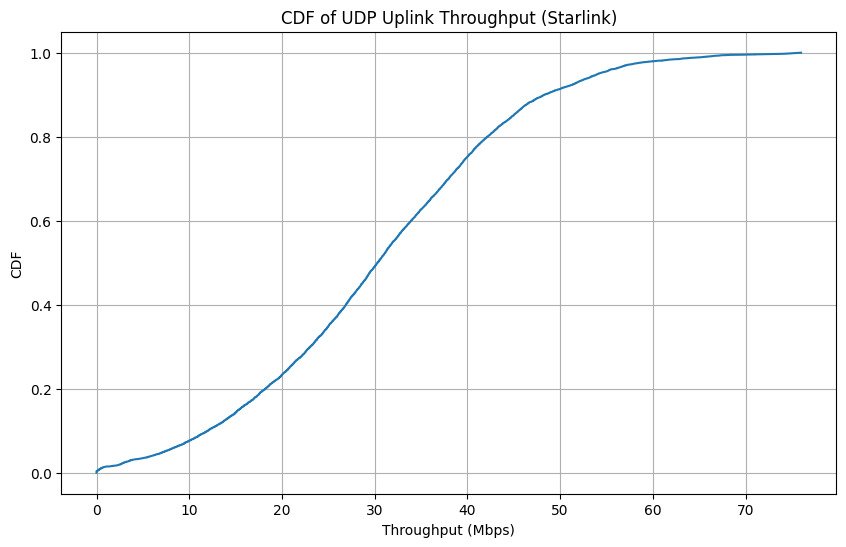

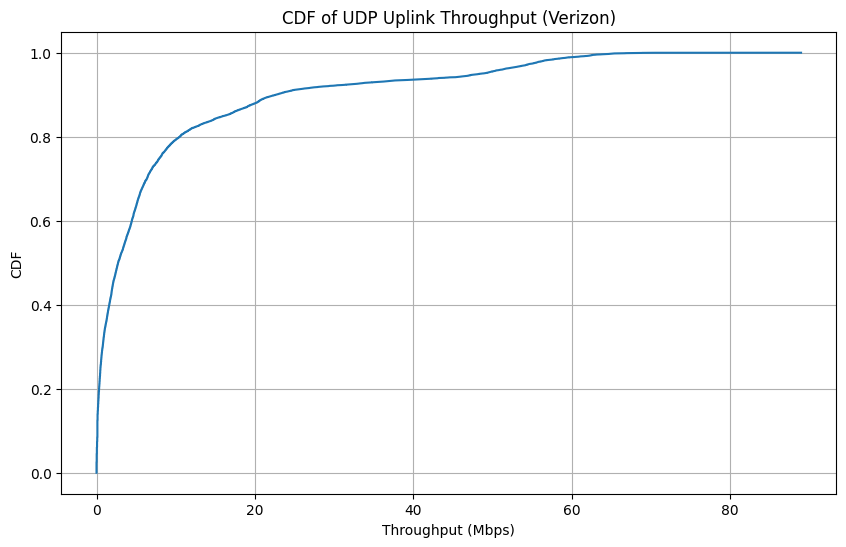

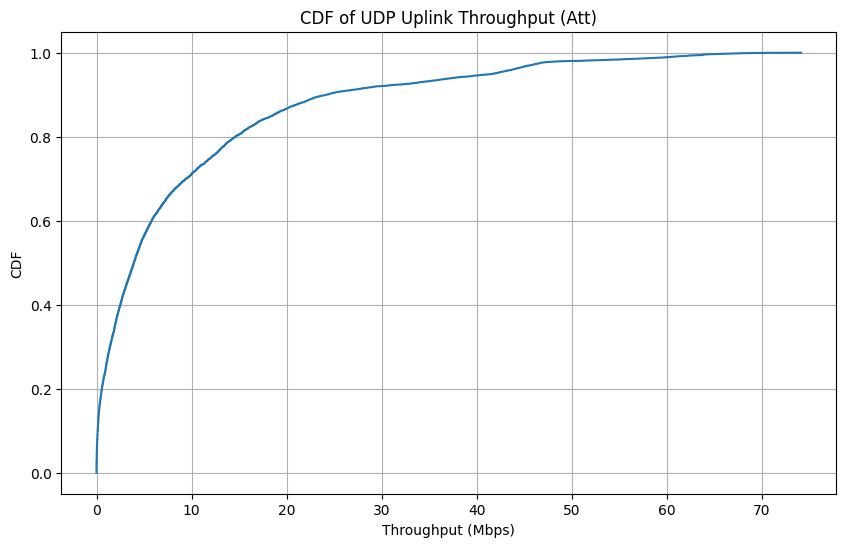

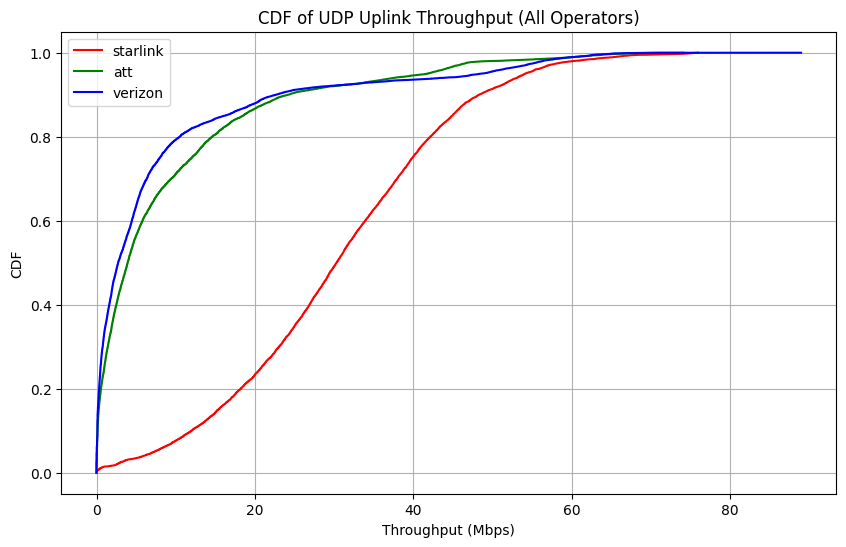

In [16]:
# Plot the CDF of throughput

output_plots_dir = os.path.join(base_directory, 'plots')
if not os.path.exists(output_plots_dir):
    os.makedirs(output_plots_dir, exist_ok=True)

# plot_tcp_downlink_data(all_tcp_downlink_df, output_dir=output_plots_dir)
# plot_tcp_uplink_data(all_tcp_uplink_df, output_dir=output_plots_dir)
plot_udp_uplink_data(df=all_udp_uplink_df, output_dir=output_plots_dir)

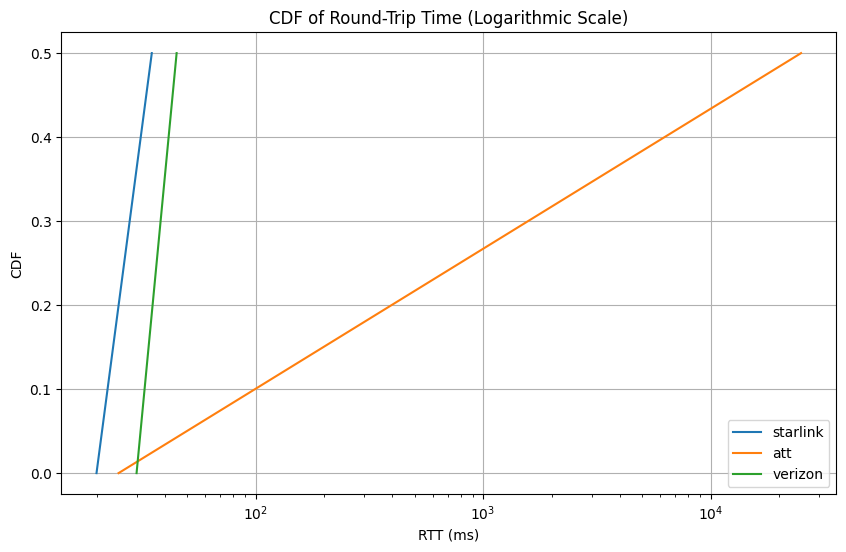

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame with RTT data
data = {
    'operator': ['starlink', 'att', 'verizon', 'starlink', 'att', 'verizon'],
    'rtt': [20, 25, 30, 35, 25000, 45]  # Sample RTT values with an outlier
}

df = pd.DataFrame(data)

# Function to plot CDF
def plot_cdf_log_scale(df, column, operator_col):
    plt.figure(figsize=(10, 6))
    
    for operator in df[operator_col].unique():
        data = df[df[operator_col] == operator][column]
        data_sorted = np.sort(data)
        cdf = np.arange(len(data_sorted)) / float(len(data_sorted))
        
        plt.plot(data_sorted, cdf, label=operator)
    
    plt.xscale('log')
    plt.xlabel('RTT (ms)')
    plt.ylabel('CDF')
    plt.legend(loc='lower right')
    plt.title('CDF of Round-Trip Time (Logarithmic Scale)')
    plt.grid(True)
    plt.show()

# Plot the CDF with logarithmic scale
plot_cdf_log_scale(df, 'rtt', 'operator')
